# P-Vales: Innocent until proven guilty

P-values are present in many linear regression libraries or toolboxes. In most cases, their usage is limited to determine if they are less than or greater than 0.05. But, what does this really mean? Why a small P-value is an evidence that a regression coefficient is not zero? The origin of P-values presents them as more than just a discrimination criterion. Since their development more than 100 years ago in a famous Irish brewery, P-values have attracted many followers as well as critics. They even might be closer to multiverses than you may think...

This Jupyter Notebook contains some of the plots that are included with the Medium article: <a href=https://towardsdatascience.com/p-values-innocent-until-proven-guilty-65cb4e93e52c>P-Values: Innocent Until Proven Guilty</a>. In addition to be used as a backup for the Medium article, the objective of this notebook is to show where do the P-values come from and how to estimate them.

### Libraries:
These are the libraries that will be used in this notebook

In [51]:
import pandas as pd #Pandas
import numpy as np #NumPy
import matplotlib.pyplot as plt #Matplotlib
import scipy.stats as stats #SciPy
from scipy.stats import t #To calculate left P-value
import statsmodels.api as sm #To perform linear regressions
import random 
import math

### Part 1:
<b>Problem:</b> Prof. Matthew Coolguy is a university professor teaching History of Early Medieval Europe. He has been teaching the same course for more than 8 semesters and he is worried about the poor performance of his students. He thinks that maybe lecturing at 7:00 am is too early for most of the students and is affecting their performance. He also thinks that the course material might have something to do with this. He uses really old slides with a lot of text and black and white pictures. Maybe if he updates the slides, reduces the amount of text and includes colourful pictures the students will be more interested in his course. Finally, one of Prof. Coolguy’s colleagues told him that he also had a similar problem and he solved it by changing classrooms. There are newer and brighter classrooms in a different building that Prof. Coolguy could use. He could move his lectures to that building and see how it goes.

The grades that are saved in the csv file `Grades_norm.csv` correspond to 4 groups of students:
- The original group of students. These are the grades that Prof. Coolguy has seen so far
- The grades that the students would obtain in a scenario where Prof. Coolguy changes the start time
- The grades that the students would obtain in a scenario where Prof. Coolguy changes the classroom
- The grades that the students would obtain in a scenario where Prof. Coolguy changes the classroom material

These grades will be stored in a dataframe named `Grades_norm`:

In [52]:
Grades_norm=pd.read_csv("Grades_norm.csv")

It is important to note that the objective of this exercise is to analyze how the P-values can be used to determine what is the influence of a variable in a population. Since we already have the distribution of all the grades we already know the results of the changes in the start time, classroom and class material.
- Most of the students will increase their grades after the change on the start time
- Most of the students will decrease their grades after the change on the classroom
- Most of the students won't see any difference after changing the classroom materials

We can visualize the distribution of grades in each one of the cases using Histograms. The following code will convert each of the columns into NumPy arrays and it will then plot each of the scenaroios as histograms.

<BarContainer object of 10 artists>

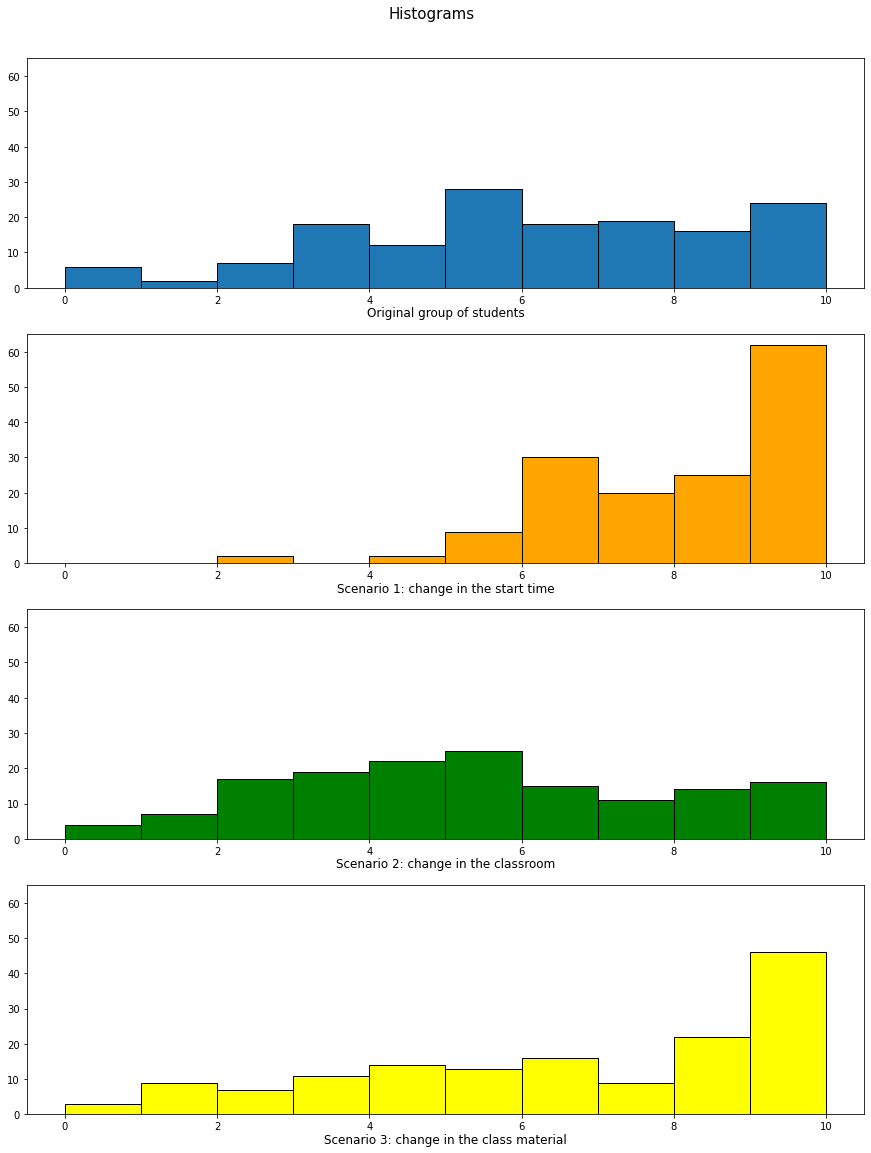

In [53]:
#Convert each column into NumPy arrays
Population=Grades_norm["Current grades"].to_numpy()
Time_multiverse=Grades_norm["Time"].to_numpy()
Grades_multiverse=Grades_norm["Classroom"].to_numpy()
Material_multiverse=Grades_norm["Material"].to_numpy()

#Build the histogram for each scenario
hist1, bins1 = np.histogram(Population, bins = range(11))
hist2, bins2 = np.histogram(Time_multiverse, bins = range(11))
hist3, bins3 = np.histogram(Grades_multiverse, bins = range(11))
hist4, bins4 = np.histogram(Material_multiverse, bins = range(11))

#Plot the histograms using the same x-axis
fig, axs = plt.subplots(4, figsize=(15,18), sharey=True)
fig.suptitle('Histograms', size=15)
#fig.tight_layout()
fig.subplots_adjust(top=0.94, hspace=0.2)
axs[0].set_title("Original group of students", y=-0.15)
axs[0].bar(bins1[:-1], hist1, width = 1, align='edge', edgecolor='k')
axs[1].set_title("Scenario 1: change in the start time", y=-0.15)
axs[1].bar(bins2[:-1], hist2, width = 1, align='edge', edgecolor='k', color='orange')
axs[2].set_title("Scenario 2: change in the classroom", y=-0.15)
axs[2].bar(bins3[:-1], hist3, width = 1, align='edge', edgecolor='k', color='green')
axs[3].set_title("Scenario 3: change in the class material", y=-0.15)
axs[3].bar(bins4[:-1], hist4, width = 1, align='edge', edgecolor='k', color='yellow')


<b>Solution:</b> We are now going write a function that considers one of the scenarios and calculate the P-value that is associated with that change. This function follows these steps:
1. Input data:

    a. Which scenario do you want to try? `Scenario`
    
    b. How many students do you want to use as sample? `number_samples` 
    
    c. How many iterations of this process do you want to implement? `iterations` 


2. Randomly select `number_samples` students from the scenario you chose
3. With these group of students calculate their average grade (`Samp_Mean`) and their standard deviation (`Samp_Std`). Also, calculate the original population average grade (`Pop_Mean`) and standard deviation (`Pop_Std`). 
4. Calculate the t-student value (in the code is called `Z_score`) using the following equation: $ \frac{(\mu_{sample}-\mu_{population})\sqrt n}{\sigma}$
5. Calculate the P-value for both the left and right tails of the t-distribution
6. Depending oh the P-value there are three possible paths:

    a. The area under the curve to the right of the t-student value is less than 0.05: this means that we <b>could</b> reject one of the null hypotheses because the possibility of finding a group of students whose average grade is <b>greater than or equal to</b> the the sample population's average <b>in a world where that change does not have any influence on the student's grades</b> is less than 0.05.
    
    b. The area under the curve to the left of the t-student value is less than 0.05: this means that we <b>could</b> reject one of the null hypotheses because the possibility of finding a group of students whose average grade is <b>less than or equal to</b> the the sample population's average <b>in a world where that change does not have any influence on the student's grades</b> is less than 0.05.
    
    c. Neither of the areas is less than 0.05: this means that we cannot reject the null hypotheses. The distribution of grades in the population we selected is not enough of a proof to establish that the changes we did have an impact on the student's grades.
   
  Independently of each of the scenarios, the process continues as follows:
  

7. Draw `iterations` random samples of `number_samples` students from the selected scenario.
8. For each of the samples calculate the average (`Means2`), standard deviation (`Stds2`) and its t-student value (`Zs_samples`)
9. Generate a normal distribution plot with the location of the original sample selected on step 2 and the average values for the rest of the samples that were drawn on step 8. The y-axis position for each of the samples that are coming from step 8 are determined randomly. This is just for visualization purposes since most of the points will be very close together. This plot will show cases in which, although we are rejecting the null hypothesis (the changes had an effect on the students), the average grade of the students is not increasing in comparison to the average grade of the original population.
10. Generate a t-distribution plot with the location of the original sample selected on step 2 and the t-student values for the rest of the samples that were drawn on step 8. The y-axis position for each of the samples that are coming from step 8 are determined randomly. This is just for visualization purposes since most of the points will be very close together. This plot will show cases in which, although the implemented changes had an effect on the students, we cannot reject the null hypothesis. This is an example of a False Negative. In this plot the shaded area below the curve represents a P-value of less than 0.05
    

In [54]:
def PValues(Grades,Scenario,number_samples,iterations=100):
    
    
#STEP 1. Decide which scenario you want to try
    Population=Grades["Current grades"].to_numpy()
    if Scenario=="Time":
        Scenario=Grades["Time"].to_numpy()
    elif Scenario=="Classroom":
        Scenario=Grades["Classroom"].to_numpy()
    elif Scenario=="Material":
        Scenario=Grades["Material"].to_numpy()
    
#STEP 2. Randomly select the sample
    Sample=np.zeros(number_samples)
    n=np.zeros(number_samples)
    for i in range(number_samples-1):
        flag=0
        while flag==0:
            flag=1
            n[i]=random.randint(0,np.size(Population)-1)
            for j in range(i):
                if n[i]==n[j]:
                    flag=0
        n=n.astype(int)
        Sample[i]=Scenario[n[i]]
    
#STEP 3. Calculate Mean and Standard Deviation for Population and Sample
    Pop_Mean=np.mean(Population)
    Pop_Std=np.std(Population)
    Samp_Mean=np.mean(Sample)
    Samp_Std=np.std(Sample, ddof=1)
    
#STEP 4. Calculate Z-score
    Z_score=(Samp_Mean-Pop_Mean)*np.sqrt(number_samples)/Samp_Std
    
#STEP 5.Calculate right-tail and left-tail P-value
    P_left=t.cdf(Z_score, df=number_samples-1)
    P_right=1-P_left
    
#STEP 6. Determine if you can reject the null Hypothesis and in which tail of the t curve you are
    if P_right<0.05:
        #Print first result
        print("The right-tail P-value is %f. You can reject the Ho because the changes DO have a positive impact on the grades" % P_right)
        
        #STEP 7. Generate multiple samples to test the P-value
        Sample2=np.zeros(number_samples)
        Means2=np.zeros(iterations)
        Stds2=np.zeros(iterations)
        Zs_samples=np.zeros(iterations)
        for k in range(iterations):
            for i in range(number_samples-1):
                flag=0
                while flag==0:
                    flag=1
                    #np.random.seed(r)
                    n[i]=random.randint(0,np.size(Population)-1)
                    for j in range(i):
                        if n[i]==n[j]:
                            flag=0
                    n=n.astype(int)
                    Sample2[i]=Scenario[n[i]]
            #STEP 8. Calculate the average, standard deviation and t-student value for the new samples
            Means2[k]=np.mean(Sample2)
            Stds2[k]=np.std(Sample2,ddof=1)
            Zs_samples[k]=(Means2[k]-Pop_Mean)*np.sqrt(number_samples)/Stds2[k]
        
        #STEP 9. Plot Normal curve with the position of test points
        x = np.linspace(Pop_Mean - 3*Pop_Std, Pop_Mean + 3*Pop_Std, 100)
        plt.figure(figsize=(15, 3)) 
        plt.plot(x, stats.norm.pdf(x, Pop_Mean, Pop_Std))
        plt.plot([Pop_Mean,Pop_Mean],[0,stats.norm.pdf(Pop_Mean, Pop_Mean, Pop_Std)], ls='--')
        color=np.where(Means2 <= Pop_Mean, 'red','black')
        #np.random.seed(r)
        random_ys=[np.random.rand()*stats.norm.pdf(Means2[i], Pop_Mean, Pop_Std) for i in range(np.size(Means2))]
        plt.scatter(Means2,random_ys,s=15,edgecolor=color, facecolors='none')
        plt.scatter(Samp_Mean,0,s=20,color='k')
        plt.title('Normal Distribution')
        plt.xlabel('x')
        plt.ylabel('P(x)')
        #plt.scatter(Means2,np.zeros(np.size(Means2)),s=5,c=color)
        plt.show()
        print("From %d random samples of %d students, there is(are) %d group(s) whose average grade is lower than the population" % (iterations, number_samples,(color=='red').sum()))       
        print()
        
        #STEP 10. Plot t curve with the position of test points
        x = np.linspace(-6, 6, 500)
        plt.figure(figsize=(15, 6)) 
        plt.plot(x, t.pdf(x, df=number_samples-1))
        #plt.plot([Z_score,Z_score],[0,t.pdf(Z_score, df=number_samples)], ls='--', color='k')
        #Fill under the curve
        plt.fill_between(x,0,t.pdf(x, df=number_samples-1),where=x>=t.isf(0.05, df=number_samples-1),alpha=0.4,color='orange')
        color=np.where(Zs_samples <= t.isf(0.05, df=number_samples-1), 'red','black')
        #np.random.seed(r)
        random_ys=[np.random.rand()*t.pdf(Zs_samples[i], df=number_samples-1) for i in range(np.size(Zs_samples))]
        plt.scatter(Zs_samples,random_ys,s=10,edgecolor=color, facecolors='none')
        plt.scatter(Z_score,0,s=20,color='k')
        plt.title("t-Student's Distribution")
        plt.xlabel('t')
        plt.ylabel('P(t)')
        #plt.scatter(Zs_samples,np.zeros(np.size(Zs_samples)),s=5,c=color)
        plt.show()
        print("From %d random samples of %d students, there is(are) %d group(s) in which the P-value wouldn't have concluded that the Ho should be rejected" % (iterations, number_samples,(color=='red').sum()))
    elif P_left<0.05:
        #Print first result
        print("The left-tail P-value is %f. You can reject the Ho because the changes DO have a negative impact on the grades" % P_left)
        
        #STEP 7. Generate multiple samples to test the P-value
        Sample2=np.zeros(number_samples)
        Means2=np.zeros(iterations)
        Stds2=np.zeros(iterations)
        Zs_samples=np.zeros(iterations)
        for k in range(iterations):
            for i in range(number_samples-1):
                flag=0
                while flag==0:
                    flag=1
                    #np.random.seed(r)
                    n[i]=random.randint(0,np.size(Population)-1)
                    for j in range(i):
                        if n[i]==n[j]:
                            flag=0
                    n=n.astype(int)
                    Sample2[i]=Scenario[n[i]]
            #STEP 8. Calculate the average, standard deviation and t-student value for the new samples
            Means2[k]=np.mean(Sample2)
            Stds2[k]=np.std(Sample2,ddof=1)
            Zs_samples[k]=(Means2[k]-Pop_Mean)*np.sqrt(number_samples)/Stds2[k]
        
        #STEP 9. Plot Normal curve with the position of test points
        x = np.linspace(Pop_Mean - 3*Pop_Std, Pop_Mean + 3*Pop_Std, 100)
        plt.figure(figsize=(15, 3)) 
        plt.plot(x, stats.norm.pdf(x, Pop_Mean, Pop_Std))
        plt.plot([Pop_Mean,Pop_Mean],[0,stats.norm.pdf(Pop_Mean, Pop_Mean, Pop_Std)], ls='--')
        color=np.where(Means2 >= Pop_Mean, 'red','black')
        #np.random.seed(r)
        random_ys=[np.random.rand()*stats.norm.pdf(Means2[i], Pop_Mean, Pop_Std) for i in range(np.size(Means2))]
        plt.scatter(Means2,random_ys,s=15,edgecolor=color, facecolors='none')
        plt.scatter(Samp_Mean,0,s=20,color='k')
        plt.title('Normal Distribution')
        plt.xlabel('x')
        plt.ylabel('P(x)')
        #plt.scatter(Means2,np.zeros(np.size(Means2)),s=5,c=color)
        plt.show()
        print("From %d random samples of %d students, there is(are) %d group(s) whose average grade is higher than the population" % (iterations, number_samples,(color=='red').sum()))       
        print()
        
        #STEP 10. Plot t curve with the position of test points
        x = np.linspace(-6, 6, 500)
        plt.figure(figsize=(15, 6)) 
        plt.plot(x, t.pdf(x, df=number_samples-1))
        #plt.plot([Z_score,Z_score],[0,t.pdf(Z_score, df=number_samples)], ls='--', color='k')
        #Fill under the curve
        plt.fill_between(x,0,t.pdf(x, df=number_samples-1),where=x<=t.isf(0.95, df=number_samples-1),alpha=0.4,color='orange')
        color=np.where(Zs_samples >= t.isf(0.95, df=number_samples-1), 'red','black')
        #np.random.seed(r)
        random_ys=[np.random.rand()*t.pdf(Zs_samples[i], df=number_samples-1) for i in range(np.size(Zs_samples))]
        plt.scatter(Zs_samples,random_ys,s=10,edgecolor=color, facecolors='none')
        plt.scatter(Z_score,0,s=20,color='k')
        plt.title("t-Student's Distribution")
        plt.xlabel('t')
        plt.ylabel('P(t)')
        #plt.scatter(Zs_samples,np.zeros(np.size(Zs_samples)),s=5,c=color)
        plt.show()
        print("From %d random samples of %d students, there is(are) %d group(s) in which the P-value wouldn't have concluded that the Ho should be rejected" % (iterations, number_samples,(color=='red').sum()))
    else:
        print("The Ho cannot be rejected according to the sample selected")
        #Plot t curve with the position of test points
        x = np.linspace(-6, 6, 500)
        plt.figure(figsize=(15, 6)) 
        plt.plot(x, t.pdf(x, df=number_samples-1))
        #plt.plot([Z_score,Z_score],[0,t.pdf(Z_score, df=number_samples)], ls='--', color='k')
        #Fill under the curve
        plt.fill_between(x,0,t.pdf(x, df=number_samples-1),where=x>=t.isf(0.05, df=number_samples-1),alpha=0.4,color='orange')
        plt.fill_between(x,0,t.pdf(x, df=number_samples-1),where=x<=t.isf(0.95, df=number_samples-1),alpha=0.4,color='orange')
        plt.scatter(Z_score,0,s=20,color='k')
        plt.title("t-Student's Distribution")
        plt.xlabel('t')
        plt.ylabel('P(t)')
        #plt.scatter(Zs_samples,np.zeros(np.size(Zs_samples)),s=5,c=color)
        plt.show()
    
    return
              

We can now call this function for each one of the scenarios:
- Change in the start time
- Change in the classroom
- Change in the class material

By default you will generate 100 iterations but you can also change increase or decrease the number of iterations. It is also important to define the sample size you want to use. Remember, this sample size is used at the beginning of the algorithm to calculate the first P-value. After this, each of the samples that is randomly selected will have the same size.

#### This is an example with a change in the start time:    

The right-tail P-value is 0.001811. You can reject the Ho because the changes DO have a positive impact on the grades


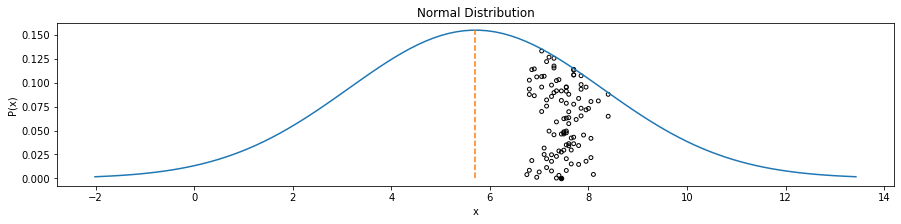

From 100 random samples of 20 students, there is(are) 0 group(s) whose average grade is lower than the population



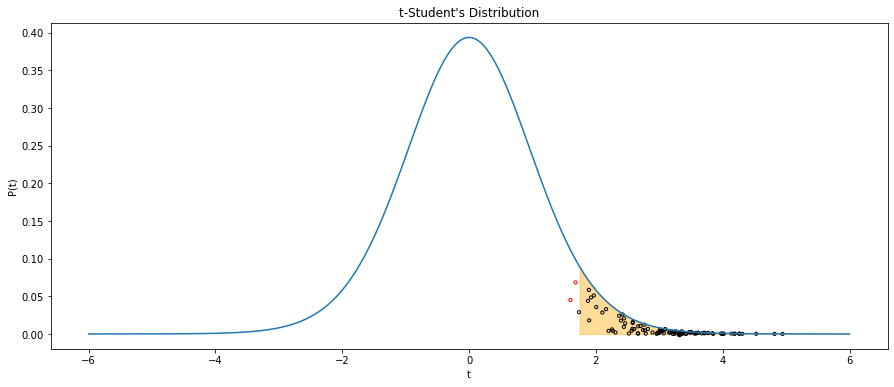

From 100 random samples of 20 students, there is(are) 2 group(s) in which the P-value wouldn't have concluded that the Ho should be rejected


In [55]:
PValues(Grades_norm,"Time",20)

#### This is an example with a change in the classroom:

The left-tail P-value is 0.001687. You can reject the Ho because the changes DO have a negative impact on the grades


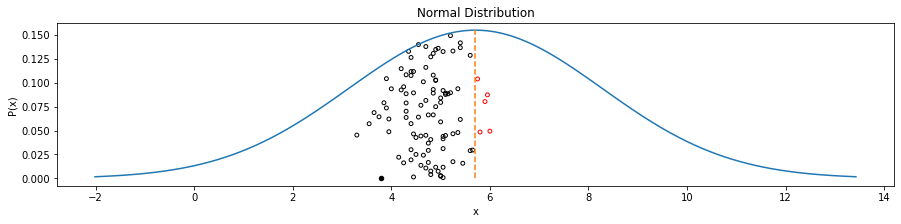

From 100 random samples of 20 students, there is(are) 5 group(s) whose average grade is higher than the population



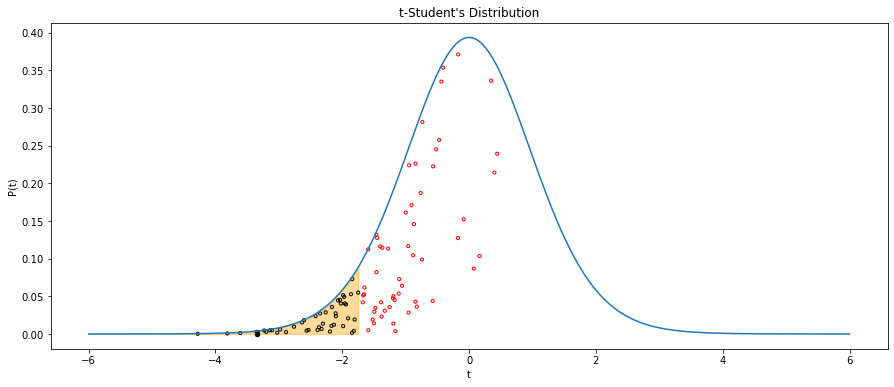

From 100 random samples of 20 students, there is(are) 55 group(s) in which the P-value wouldn't have concluded that the Ho should be rejected


In [56]:
PValues(Grades_norm,"Classroom",20)

#### This is an example with a change in the class material:

The Ho cannot be rejected according to the sample selected


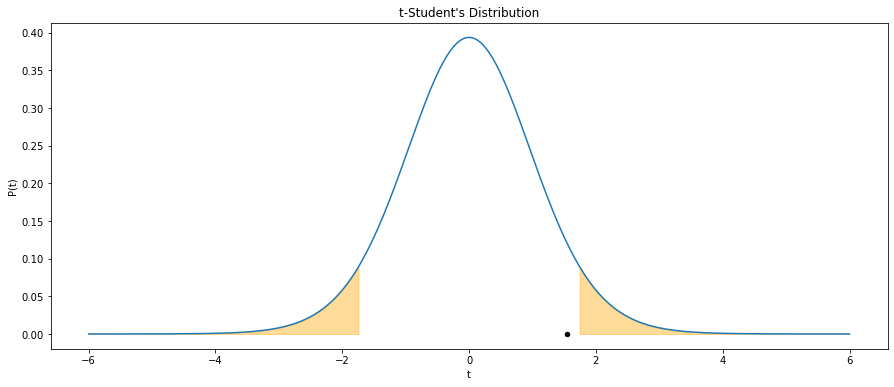

In [69]:
PValues(Grades_norm,"Material",20)

### Part 2:
<b>Problem:</b> We would like to find a correlation between driver's age and the distance at which they are able to see a highway sign. This dataset is taken from the <a href="https://online.stat.psu.edu/stat501/lesson/2/2.12">Example 2-5: Highway Sign Reading Distance and Driver Age</a> in the <a href="https://online.stat.psu.edu/stat501/">STAT 501-PennState page.</a> The dataset is saved in `Age_Distance.csv`. For this first part we will use column 1 (Age) and column 2 (Distance). The third column will be used in a different exercise.

Let's save the dataset in variable named `AD` and plot its values

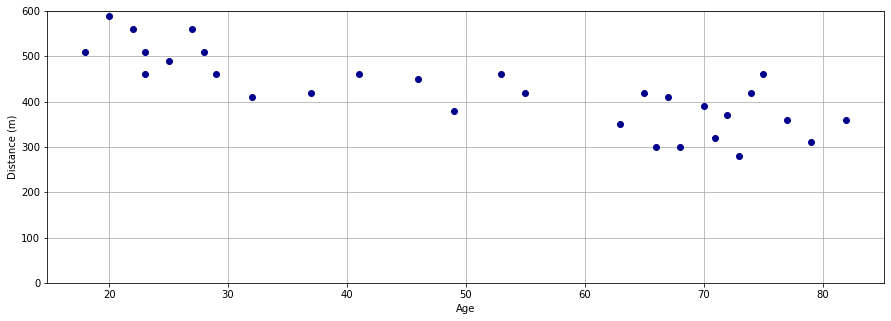

In [58]:
AD=pd.read_csv("Age_Distance.csv")
plt.figure(figsize=(15, 5))
plt.xlabel('Age')
plt.ylabel('Distance (m)')
plt.ylim(0,600)
plt.grid(zorder=1.0)
plt.scatter(AD['Age'], AD['Distance'], color='darkblue',zorder=2.0)
plt.show()

<b>Solution:</b> We can use the <a href=https://www.statsmodels.org/stable/index.html>statsmodels</a> library to generate a linear regression and obtain the parameters that best fit the results. In this case, we would like to have a function of the type $Distance=a_0+a_1*Age$. To calculate this we will define a variable $Y$ that contains the independent variable, distances; and a variable $X$ that corresponds to the ages. Because we want a bias term, we will use the function `add_constant` to modify $X$ such that we obtain $a_0$ and $a_1$


In [59]:
X=AD['Age']
Y=AD['Distance']
X=sm.add_constant(X)
linear_model=sm.OLS(Y,X)
linear_fit=linear_model.fit()
linear_fit.summary()

C:\Users\Manfre\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Distance   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     50.21
Date:                Wed, 11 May 2022   Prob (F-statistic):           1.04e-07
Time:                        15:41:10   Log-Likelihood:                -158.75
No. Observations:                  30   AIC:                             321.5
Df Residuals:                      28   BIC:                             324.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        576.6819     23.471     24.570      0.000     528.604     624.760
Age           -3.0068      0.424     -7.086      0.000      -3.876      -2.138
==============================================================================
Omnibus:                        0.684   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.710
Skew:                           0.125   Prob(JB):                        0.701
Kurtosis:                       2.289   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After performing the linear regression, we get the following coefficients:

In [60]:
print("a0:",linear_fit.params[0])
print("a1:",linear_fit.params[1])

a0: 576.6819371727748
a1: -3.0068353694008136


And this is how it would look if we try to plot the function and the data points together:

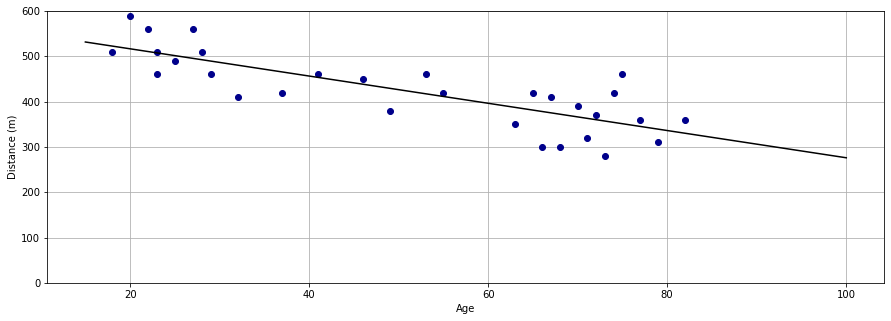

In [61]:
x = np.linspace(15, 100, 2)
y = linear_fit.params[0]+linear_fit.params[1]*x
plt.figure(figsize=(15, 5))
plt.xlabel('Age')
plt.ylabel('Distance (m)')
plt.ylim(0,600)
plt.grid(zorder=1.0)
plt.scatter(AD['Age'], AD['Distance'], color='darkblue',zorder=2.0)
plt.plot(x,y,color='black')
plt.show()

The P-values for these coefficients are:

In [62]:
print("P-value for a0:",linear_fit.pvalues[0])
print("P-value for a1:",linear_fit.pvalues[1])

P-value for a0: 1.7251124207421908e-20
P-value for a1: 1.0409975572931604e-07


As you can see, these are really small values. Considerably smaller than 0.05. In this case this means that we cannot reject the null hypothesis which is another way of saying that we have statistically significant evidence that these two coefficients are not zero. The process by which these P-values are calculated is not that different from the process showed in Part 1. This is better explained in the Medium article mentioned at the beginning of this notebook.
Now, let's imagine that we have a different dataset of Distances vs Age and this time it looks like this:

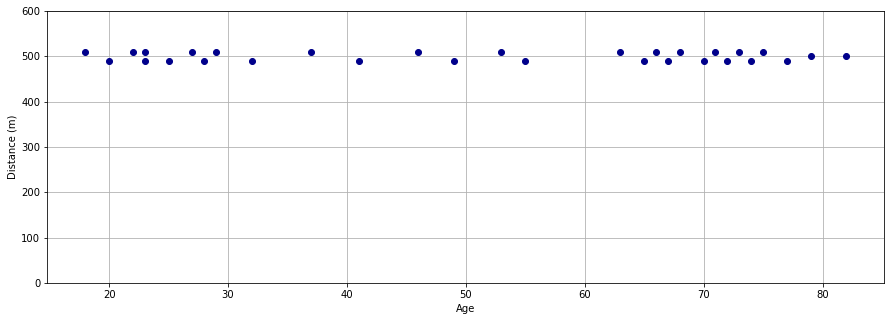

In [63]:
plt.figure(figsize=(15, 5))
plt.xlabel('Age')
plt.ylabel('Distance (m)')
plt.ylim(0,600)
plt.grid(zorder=1.0)
plt.scatter(AD['Age'], AD['Distance1'], color='darkblue',zorder=2.0)
plt.show()

We can use statsmodels again to calculate to perform the linear regression:

In [64]:
Y2=AD['Distance1']
linear_model2=sm.OLS(Y2,X)
linear_fit2=linear_model2.fit()
linear_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Distance1   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                   0.05311
Date:                Wed, 11 May 2022   Prob (F-statistic):              0.819
Time:                        15:41:10   Log-Likelihood:                -110.58
No. Observations:                  30   AIC:                             225.2
Df Residuals:                      28   BIC:                             228.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        501.0013      4.712    106.320      0.000     491.349     510.654
Age           -0.0196      0.085     -0.230      0.819      -0.194       0.155
==============================================================================
Omnibus:                      126.367   Durbin-Watson:                   3.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.618
Skew:                          -0.013   Prob(JB):                       0.0993
Kurtosis:                       1.078   Cond. No.                         143.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This time, the coefficients are:

In [65]:
print("a0:",linear_fit2.params[0])
print("a1:",linear_fit2.params[1])

a0: 501.00130890052344
a1: -0.0196335078534024


And this is how it would look if we try to plot the function and the data points together:

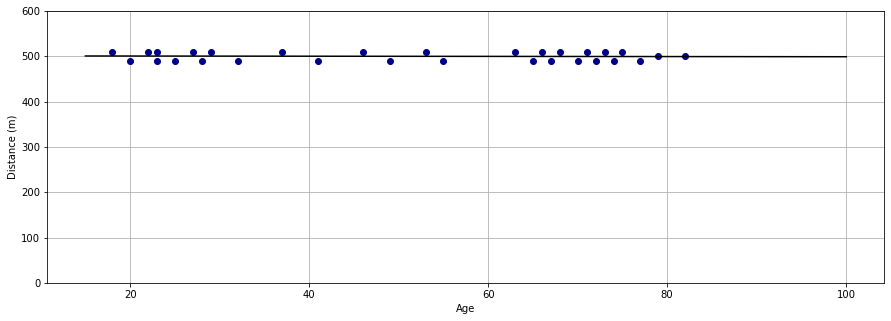

In [66]:
x = np.linspace(15, 100, 2)
y = linear_fit2.params[0]+linear_fit2.params[1]*x
plt.figure(figsize=(15, 5))
plt.xlabel('Age')
plt.ylabel('Distance (m)')
plt.ylim(0,600)
plt.grid(zorder=1.0)
plt.scatter(AD['Age'], AD['Distance1'], color='darkblue',zorder=2.0)
plt.plot(x,y,color='black')
plt.show()

The P-values for these coefficients are:

In [67]:
print("P-value for a0:",linear_fit2.pvalues[0])
print("P-value for a1:",linear_fit2.pvalues[1])

P-value for a0: 4.730767841895996e-38
P-value for a1: 0.8194112040844459


This time the P-value for $a_1$ is greater than 0.05. A visual inspection of the previous plot can give us a hint about this. The way in which the points are now aligned is not strongly related to the slope of the curve. Actually, we could disregard $a_1$ and we would end up with a fit that is very similar to the one we just obtained. This means that this time we have statistically significant evidence that the coefficient $a_1$ is zero.

### Conclusion:

The objective of this notebook was to present a simple example that illustrates how the P-values are calculated and what do they mean. Since they appear in most linear regressions packages or libraries it is important to understand them. In many cases they are used to separate significant coefficients from not significant ones. However, the essence of P-values goes beyond a discrimination criteria. 